## **Preparing all things**

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.5MB 13.3MB/s 
     |████████████████████████████████| 890kB 52.7MB/s 
     |████████████████████████████████| 2.9MB 57.8MB/s 


In [ ]:
from google.colab import files, auth, drive
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import copy
import re
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC# Support Vector Machine
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from collections import defaultdict
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

## **Setup & Config**


In [ ]:
CUDA_LAUNCH_BLOCKING=1

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using CUDA


In [ ]:
# Mount to drive
drive.mount('/content/gdrive', force_remount=True)
data_dir_drive ='/content/gdrive/My Drive/Colab Notebooks/Information Retrieval and Text Mining/'
data_dir ='/content' # When read from unziped file

Mounted at /content/gdrive


In [ ]:
import nltk

# stopwords, punkt, wordnet 
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Unzipping tokenizers/punkt.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Package wordnet is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
df = pd.read_csv(data_dir_drive + 'Lyrics-Genre-Train.csv')

## **Data Analysis**

In [ ]:
df

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260
...,...,...,...,...,...,...
18508,i-wish-he-didn-t-trust-me-so-much,2008,bobby-womack,R&B,I'm the best friend he's got\nI'd give him the...,12033
18509,i-totally-miss-you,2006,bad-boys-blue,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you...",15987
18510,sorry-for-love,2002,celine-dion,Pop,Forgive me for the things\nThat I never said t...,2722
18511,cure-for-aids,2008,dan-bern,Indie,The day they found a cure for AIDS\nThe day th...,10221


In [ ]:
# The describe method shows basic statistical characteristics of each 
# numerical feature (int64 and float64 types): number of non-missing values, 
# mean, standard deviation, range, median, 0.25 and 0.75 quartiles.
df.describe()

,Song year,Track_id
count,18513.000000,18513.000000
mean,2007.780641,13206.886458
std,14.906961,7644.942910
min,112.000000,0.000000
25%,2006.000000,6573.000000
50%,2007.000000,13254.000000
75%,2011.000000,19833.000000
max,2016.000000,26447.000000


In [ ]:
# print same iformations about each column for table
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18513 entries, 0 to 18512
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Song       18513 non-null  object
 1   Song year  18513 non-null  int64 
 2   Artist     18513 non-null  object
 3   Genre      18513 non-null  object
 4   Lyrics     18513 non-null  object
 5   Track_id   18513 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 867.9+ KB
None


As there are no missing values, it means that I do not have to throw lines or rebuild them

In [ ]:
data = df.to_numpy()

['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
[1890, 1540, 1153, 2240, 1190, 1540, 1890, 2590, 1190, 3290]


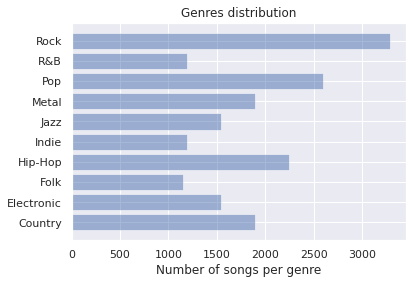

Country have 1890 songs
Electronic have 1540 songs
Folk have 1153 songs
Hip-Hop have 2240 songs
Indie have 1190 songs
Jazz have 1540 songs
Metal have 1890 songs
Pop have 2590 songs
R&B have 1190 songs
Rock have 3290 songs


In [ ]:
# The distribution of songs by genres
genres = data[:, 3]
objects = sorted(set(genres))
print(objects)
y_pos = np.arange(len(objects))
nr = []
for genre in objects:
    nr.append(np.sum((genres == genre)))
print(nr)
plt.barh(y_pos, nr, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Number of songs per genre')
plt.title('Genres distribution')

plt.show()

for idx in range(len(objects)):
    print(objects[idx] + ' have ' + str(nr[idx]) + ' songs')

It's like we have at least 1000 lyrics for each musical genre. Classes are unbalanced

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


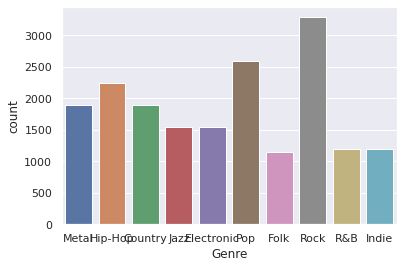

In [ ]:
sns.countplot(df.Genre)
plt.xlabel('Genre');

In [ ]:
genres = set(df['Genre'])
genres

{'Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock'}

In [ ]:
N = 1000 # number of records to pull from each genre
RANDOM_SEED = 43 # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres: # loop over each genre
    print(genre)
    subset = df[(df.Genre==genre)]
    train_set = subset.sample(n=N, random_state=RANDOM_SEED) # 1000 verses of 
    #each genre are put in the train set, the network will go in the test set
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set)
    test_df = test_df.append(test_set)
    
train_df = shuffle(train_df)
test_df = shuffle(test_df)

Electronic
Pop
Rock
Metal
Country
Indie
R&B
Hip-Hop
Jazz
Folk


# **Classic ML algorithms**
## **Naive Bayes with CountVectorizer as a feature extraction**

In [ ]:
# define model
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train model on training data
text_clf.fit(train_df.Lyrics, train_df.Genre)  

# score model on testing data
predicted = text_clf.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.38306120051685655
              precision    recall  f1-score   support

  Electronic       0.43      0.46      0.44       890
         Pop       0.19      0.15      0.16       540
        Rock       0.12      0.35      0.18       153
       Metal       0.73      0.78      0.75      1240
     Country       0.08      0.42      0.13       190
       Indie       0.32      0.31      0.32       540
         R&B       0.57      0.69      0.63       890
     Hip-Hop       0.39      0.28      0.32      1590
        Jazz       0.09      0.38      0.14       190
        Folk       0.49      0.17      0.25      2290

    accuracy                           0.38      8513
   macro avg       0.34      0.40      0.33      8513
weighted avg       0.45      0.38      0.39      8513



## **Naive Bayes with Tfid as a feature extraction**

---



In [ ]:
# define model
text_Tfidf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train model on training data
text_Tfidf.fit(train_df.Lyrics, train_df.Genre)  

# score model on testing data
predicted = text_Tfidf.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.3859978855867497
              precision    recall  f1-score   support

  Electronic       0.39      0.55      0.46       890
         Pop       0.20      0.11      0.14       540
        Rock       0.15      0.30      0.20       153
       Metal       0.70      0.80      0.75      1240
     Country       0.07      0.36      0.12       190
       Indie       0.36      0.30      0.33       540
         R&B       0.63      0.65      0.64       890
     Hip-Hop       0.36      0.34      0.35      1590
        Jazz       0.08      0.39      0.13       190
        Folk       0.48      0.12      0.20      2290

    accuracy                           0.39      8513
   macro avg       0.34      0.39      0.33      8513
weighted avg       0.45      0.39      0.38      8513



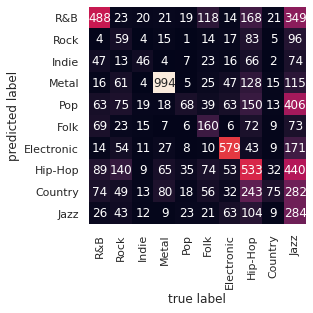

In [ ]:
mat = confusion_matrix(test_df.Genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

## **SVM**

In [ ]:
# define model
text_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel='rbf'))])

# train model on training data
text_svm.fit(train_df.Lyrics, train_df.Genre)  

# score model on testing data
predicted = text_svm.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.36826030776459534
              precision    recall  f1-score   support

  Electronic       0.43      0.38      0.40       890
         Pop       0.16      0.29      0.20       540
        Rock       0.08      0.39      0.13       153
       Metal       0.83      0.73      0.78      1240
     Country       0.08      0.36      0.14       190
       Indie       0.31      0.34      0.32       540
         R&B       0.60      0.65      0.63       890
     Hip-Hop       0.40      0.24      0.30      1590
        Jazz       0.08      0.30      0.13       190
        Folk       0.48      0.17      0.25      2290

    accuracy                           0.37      8513
   macro avg       0.34      0.39      0.33      8513
weighted avg       0.47      0.37      0.39      8513



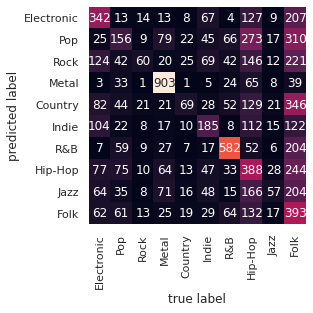

In [ ]:
mat = confusion_matrix(test_df.Genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

SVM has a lower accuracy than Naive Bayes probably because the Soft-margin is too high, or because too many features from the lyrics are close in the vector space between the Soft-margins.

## **Naive Bayes with Tfid as a feature extraction + text preprocessing**

In [ ]:
stop = list(set(stopwords.words('english'))) # stopwords

# define model
text_clf_more = Pipeline(
    [('vect', TfidfVectorizer(
        stop_words=stop # remove stopwords
        )),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train model on training data
text_clf_more.fit(train_df.Lyrics, train_df.Genre)  

# score model on testing data
predicted = text_clf_more.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.37707036297427465
              precision    recall  f1-score   support

  Electronic       0.37      0.50      0.43       890
         Pop       0.18      0.14      0.16       540
        Rock       0.14      0.33      0.20       153
       Metal       0.69      0.81      0.74      1240
     Country       0.07      0.32      0.12       190
       Indie       0.32      0.31      0.31       540
         R&B       0.59      0.66      0.62       890
     Hip-Hop       0.36      0.29      0.32      1590
        Jazz       0.09      0.39      0.14       190
        Folk       0.46      0.13      0.20      2290

    accuracy                           0.38      8513
   macro avg       0.33      0.39      0.32      8513
weighted avg       0.43      0.38      0.37      8513



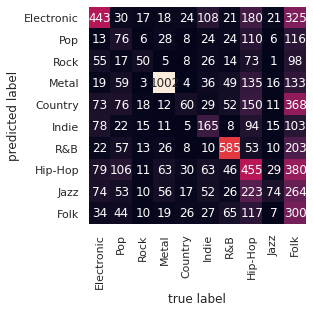

In [ ]:
mat = confusion_matrix(test_df.Genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

If I remove stopwords I decrease the accuracy from 0.386 to 0.377, almost by 1%, so removing stopwords does not help in this case

In [ ]:
stop = list(set(stopwords.words('english'))) # stopwords
lm = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        lm.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) > 2 and w.isalnum() # only words that have more than 2 characters
    )                                 # and is alpha-numeric

# define model
text_clf_more = Pipeline(
    [('vect', TfidfVectorizer(
        tokenizer=tokenizer,
        stop_words=stop, # remove stopwords
        max_df=0.4, # ignore terms that appear in more than 40% of songs
        min_df=4)), # ignore terms that appear in less than 4 songs
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train model on training data
text_clf_more.fit(train_df.Lyrics, train_df.Genre)  

# score model on testing data
predicted = text_clf_more.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy 0.37072712322330553
              precision    recall  f1-score   support

  Electronic       0.40      0.43      0.42       890
         Pop       0.15      0.17      0.16       540
        Rock       0.13      0.39      0.19       153
       Metal       0.71      0.79      0.75      1240
     Country       0.07      0.31      0.12       190
       Indie       0.30      0.35      0.33       540
         R&B       0.58      0.66      0.61       890
     Hip-Hop       0.36      0.27      0.31      1590
        Jazz       0.08      0.32      0.13       190
        Folk       0.44      0.14      0.21      2290

    accuracy                           0.37      8513
   macro avg       0.32      0.38      0.32      8513
weighted avg       0.43      0.37      0.37      8513



And if I do a little extra: elimination of stopwords, lemmatization, elimination of repetitive words that are excessive or that do not appear at all, I decrease the sharpness again by 0.7%. So it's a stupid idea



## **Logistic regression**

In [ ]:
# define model
logreg = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(n_jobs=1, multi_class = "multinomial", 
                                           C=1, solver = "sag", class_weight="balanced")),
                 ])

logreg.fit(train_df.Lyrics, train_df.Genre)

predicted = logreg.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.3686127099729825
              precision    recall  f1-score   support

  Electronic       0.41      0.42      0.42       890
         Pop       0.16      0.26      0.20       540
        Rock       0.08      0.40      0.14       153
       Metal       0.78      0.77      0.78      1240
     Country       0.08      0.33      0.13       190
       Indie       0.27      0.35      0.31       540
         R&B       0.55      0.68      0.61       890
     Hip-Hop       0.39      0.22      0.28      1590
        Jazz       0.09      0.30      0.13       190
        Folk       0.50      0.15      0.23      2290

    accuracy                           0.37      8513
   macro avg       0.33      0.39      0.32      8513
weighted avg       0.46      0.37      0.37      8513



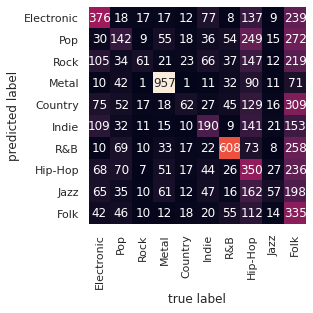

In [ ]:
mat = confusion_matrix(test_df.Genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

## **Logistic regression + text preprocessing**

In [ ]:
def clean_text(text):
    text = text.lower() # lowercase text
    text = re.compile('[/(){}\[\]\|@,;|\n]').sub(' ', text) # replace symbols by space in text
    text = re.compile('[^0-9a-z #+_]').sub('', text) # delete symbols
    text = ' '.join(word for word in text.split() if word not in list(set(stopwords.words('english')))) # delete stopwors from text
    return text
    
lyrics = train_df.Lyrics.apply(clean_text)

# define model
logreg2 = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(n_jobs=1, multi_class = "multinomial", 
                                           C=1, solver = "sag", class_weight="balanced")),
                 ])

logreg2.fit(lyrics, train_df.Genre)

predicted = logreg2.predict(test_df.Lyrics)
print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.34664630565018206
              precision    recall  f1-score   support

  Electronic       0.44      0.28      0.34       890
         Pop       0.14      0.29      0.19       540
        Rock       0.06      0.44      0.11       153
       Metal       0.81      0.73      0.76      1240
     Country       0.09      0.27      0.14       190
       Indie       0.28      0.40      0.33       540
         R&B       0.48      0.76      0.59       890
     Hip-Hop       0.39      0.16      0.23      1590
        Jazz       0.10      0.28      0.14       190
        Folk       0.48      0.14      0.22      2290

    accuracy                           0.35      8513
   macro avg       0.33      0.38      0.30      8513
weighted avg       0.45      0.35      0.35      8513



And if I do a little extra: elimination of stopwords and elimination of intuetivly bad character, I decrease the sharpness again by 2%. So it's a stupid idea, again

In [ ]:
predicted1 = text_clf.predict(test_df.Lyrics)
predicted2 = text_svm.predict(test_df.Lyrics)
predicted3 = text_Tfidf.predict(test_df.Lyrics)
predicted4 = text_clf_more.predict(test_df.Lyrics)
predicted5 = logreg.predict(test_df.Lyrics)

In [ ]:
predicted = []
for i in range(len(predicted1)):
    L = [predicted1[i], predicted2[i], predicted3[i], predicted4[i], predicted5[i]]
    predicted.append(max(set(L), key = L.count))

print('accuracy %s' % accuracy_score(predicted, test_df.Genre))
print(classification_report(test_df.Genre, predicted, target_names=genres))

accuracy 0.3814166568777164
              precision    recall  f1-score   support

  Electronic       0.41      0.49      0.45       890
         Pop       0.18      0.19      0.18       540
        Rock       0.12      0.35      0.18       153
       Metal       0.75      0.79      0.77      1240
     Country       0.08      0.40      0.13       190
       Indie       0.33      0.33      0.33       540
         R&B       0.57      0.69      0.63       890
     Hip-Hop       0.39      0.27      0.32      1590
        Jazz       0.09      0.38      0.14       190
        Folk       0.49      0.13      0.21      2290

    accuracy                           0.38      8513
   macro avg       0.34      0.40      0.33      8513
weighted avg       0.46      0.38      0.38      8513



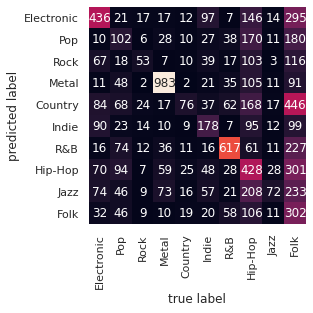

In [ ]:
mat = confusion_matrix(test_df.Genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');


Now if I implement a voting system based on the above classifiers I get the best accuracy so far 38.14% (random forest principle)

________________________________________________________________________________________________
# **MLP (Multilayer perceptron)**

In [ ]:
df = pd.read_csv(data_dir_drive + 'Lyrics-Genre-Train.csv')

In [ ]:
def to_code(genre):
    if genre  == 'Country':
        return 0
    elif genre  == 'Electronic':
        return 1
    elif genre  == 'Folk':
        return 2
    elif genre  == 'Hip-Hop':
        return 3
    elif genre  == 'Indie':
        return 4
    elif genre  == 'Jazz':
        return 5
    elif genre  == 'Metal':
        return 6
    elif genre  == 'Pop':
        return 7
    elif genre  == 'R&B':
        return 8
    else: 
        return 9

df['Genre'] = df.Genre.apply(to_code)
del df['Song']
del df['Song year']
del df['Artist']
del df['Track_id']

In [ ]:
df.head()

,Genre,Lyrics
0,6,"I am a night in to the darkness, only soul los..."
1,3,"Yeah\nSometimes, i just wanna fly away.\nThey ..."
2,6,Do you work hard?\nDo you work hard?\nYou don'...
3,3,You know what? I'm destined to be the last man...
4,0,There ain't nothing that I would rather see\nT...


In [ ]:
df_test = pd.read_csv(data_dir_drive + 'Lyrics-Genre-Test-GroundTruth.csv')
df_test.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


In [ ]:
df_test['Genre'] = df_test.Genre.apply(to_code)
del df_test['Song']
del df_test['Song year']
del df_test['Artist']
del df_test['Track_id']

In [ ]:
df_test.head()

,Genre,Lyrics
0,3,Most folks spend their days daydreaming of fin...
1,4,Take your cold hands and put them on my face\n...
2,6,Are you ready it's time for war\nWe'll break d...
3,7,You ask me why I change the color of my hair\n...
4,3,Do you believe in magic in a young girl's hear...


In [ ]:
#def process_lyrics(lyrics):
#    lyrics = lyrics.replace('\n', '')
#    lyrics = lyrics.lower()
#    lyrics = re.sub(r'[^\w\s]','', lyrics) 
#    wnl = WordNetLemmatizer() # lemmatizer
#    new_lyrics = ""
#    for word in word_tokenize(lyrics):
#        w = wnl.lemmatize(word) 
#        new_lyrics += w + " "
#    return new_lyrics
#
#df['Lyrics'] = df.Lyrics.apply(process_lyrics)

Accuracy without stopords and with preprocessing is again lower (that's why this cell is commented)

In [ ]:
tfidf = TfidfVectorizer(binary=True, max_features = 512)

x = tfidf.fit_transform(df.Lyrics)
y = df.Genre

In [ ]:
seed = 43
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=seed) # 80%-20% split

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(14810, 512) (14810,) (3703, 512) (3703,)


In [ ]:
x_train = torch.tensor(x_train.todense()).type(torch.float).cuda()
x_val = torch.tensor(x_val.todense()).type(torch.float).cuda()
y_train = torch.from_numpy(y_train.values).type(torch.long).cuda()
y_val = torch.from_numpy(y_val.values).type(torch.long).cuda()

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()

In [ ]:
class Net(nn.Module):
    # nn.Module - base class for all models
    # easy acces to .parameters() and .zero_grad()
    # define .forward() instead of __call__()
    
    def __init__(self, in_size, h_size1, h_size2, h_size3, out_size):
        super().__init__()
        self._layer1 = nn.Linear(in_size,h_size1).cuda()
        self._layer2 = nn.Linear(h_size1,h_size2).cuda()
        self._layer3 = nn.Linear(h_size2,h_size3).cuda()
        self._layer4 = nn.Linear(h_size3,out_size).cuda()
        self.drop_layer = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self._layer1(x)).cuda()
        x = self.drop_layer(x).cuda()
        x = F.relu(self._layer2(x)).cuda()
        x = self.drop_layer(x).cuda()
        x = F.relu(self._layer3(x)).cuda()
        x = self.drop_layer(x).cuda()
        x = self._layer4(x).cuda()
        return x.cuda()
        
    def train(self, train_data, train_labels, 
              epochs=400, lr=0.01, verbose=100, l2_weight=0,
              val_data=None, val_labels=None):
        #use optimizers to take care of the update step
        optimizer1 = torch.optim.SGD(self.parameters(), lr=lr,
                               weight_decay = l2_weight)
        
        optimizer2 = torch.optim.Adagrad(self.parameters())
        optimizer3 = torch.optim.RMSprop(self.parameters())
        optimizer4 = torch.optim.Adam(self.parameters())
        
        criterion = nn.CrossEntropyLoss(); # classification
        best_model_wts = copy.deepcopy(self.state_dict())
        
        train_loss = []
        val_loss = []
        best_acc = 0
        for e in range(epochs):
            optimizer4.zero_grad()   # zero the gradient buffers
            input = train_data
            output = self(train_data)
            loss = criterion(output, train_labels)
            loss.backward()
            optimizer4.step()    # Does the update of gredients
            
            train_loss.append(loss.cpu().detach().numpy())
            if verbose!=0 and e%verbose==0:
                print("Epoch :" + str(e))
                print("Loss - train :")
                print(loss)
            if val_data is not None:
                output = self(val_data)
                loss = criterion(output, val_labels)

                outputs = torch.argmax(output, dim = 1)
                avg_acc_val = torch.sum(val_labels == outputs).item() / outputs.shape[0]
                if avg_acc_val > best_acc:
                    best_acc = avg_acc_val
                    best_model_wts = copy.deepcopy(self.state_dict()) #I remember the best model for every epoch

                if verbose!=0 and e%verbose==0:
                    print("Loss - validation :")
                    print(loss)
                val_loss.append(loss.cpu().detach().numpy())

        torch.cuda.empty_cache()
            
        plot_loss(train_loss, 'train-loss')
        if len(val_loss)>0:
            plot_loss(val_loss, 'val-loss', color='red')
            plt.show()

        return best_model_wts

In [ ]:
#define a net
net = Net(512, 16* 512, 16 * 512, 16 * 512, 10)
net.to(device)
print(net)

Net(
  (_layer1): Linear(in_features=512, out_features=8192, bias=True)
  (_layer2): Linear(in_features=8192, out_features=8192, bias=True)
  (_layer3): Linear(in_features=8192, out_features=8192, bias=True)
  (_layer4): Linear(in_features=8192, out_features=10, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)


Epoch :0
Loss - train :
tensor(2.3029, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(5.1651, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :10
Loss - train :
tensor(2.2827, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(2.2783, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :20
Loss - train :
tensor(2.2430, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(2.2377, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :30
Loss - train :
tensor(2.1936, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(2.1753, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :40
Loss - train :
tensor(2.0493, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(2.0500, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :50
Loss - train :
tensor(1.9567, device='cuda:0', grad_fn=<NllLossBackward>)
Loss - validation :
tensor(1.9865, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :60
Loss - train 

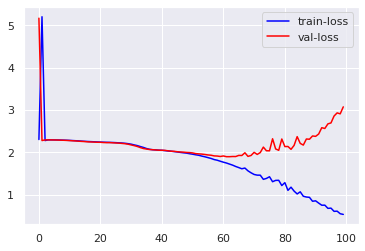

In [ ]:
#train from all examples from train set
best_model_wts = net.train(x_train, y_train, epochs=100, lr=0.1, verbose=10, val_data = x_val, val_labels=y_val)

I can see that there is a learning curve, but the network is overfitting, so the best model is saved around the epoch of 50 out of 100.

In [ ]:
net.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
#torch.save(net.state_dict(), data_dir_drive + 'models/MLP1.pt')

In [ ]:
x_test = tfidf.transform(df_test.Lyrics)
y_test = df_test.Genre

x_test = torch.tensor(x_test.todense()).type(torch.float).cuda()
y_test = torch.from_numpy(y_test.values).type(torch.long).cuda()

In [ ]:
outputs = net(x_test)
outputs = torch.argmax(outputs, dim = 1)

In [ ]:
print(outputs)
print(y_test)
acc = torch.sum(y_test == outputs).item() / outputs.shape[0]
print(acc)

tensor([6, 9, 1,  ..., 3, 9, 0], device='cuda:0')
tensor([3, 4, 6,  ..., 3, 9, 9], device='cuda:0')
0.34102079395085066


The accuracy on the test set is 34.1% quite low compared to SVM or NB. That is why I will further define 9 networks with different architectures that I will train separately and in the end the most probable prediction of the 9 votes is the vote.

In [ ]:
#define nets
net1 = Net(512, 2* 512, 2 * 512, 2 * 512, 10)
net1.to(device)

net2 = Net(512, 4* 512, 4 * 512, 4 * 512, 10)
net2.to(device)

net3 = Net(512, 8* 512, 8 * 512, 8 * 512, 10)
net3.to(device)

net4 = Net(512, 16* 512, 16 * 512, 16 * 512, 10)
net4.to(device)

net5 = Net(512, 16* 512, 8 * 512, 16 * 512, 10)
net5.to(device)

net6 = Net(512, 8* 512, 16 * 512, 32 * 512, 10)
net6.to(device)

net7 = Net(512, 8* 512, 16 * 512, 8 * 512, 10)
net7.to(device)

net8 = Net(512, 4* 512, 32 * 512, 4 * 512, 10)
net8.to(device)

net9 = Net(512, 2* 512, 64 * 512, 4 * 512, 10)
net9.to(device)

nets = [net1, net2, net3, net4, net5, net6, net7, net8, net9]

In [ ]:
#train from all examples from train set
for i in range(9):
    print(i)
    best_model_wts = nets[i].train(x_train, y_train, epochs=100, lr=0.1, verbose=100, val_data = x_val, val_labels=y_val)
    nets[i].load_state_dict(best_model_wts)
    torch.save(nets[i].state_dict(), data_dir_drive + 'MLP' + str(i) + '.pt')

In [ ]:
for i in range(9):
    print(i)
    state_dict = torch.load(data_dir_drive + 'MLP' + str(i) + '.pt', map_location=device)
    nets[i].load_state_dict(state_dict)

0
1
2
3
4
5
6
7
8


In [ ]:
predicted = []
for i in range(9):
    predicted.append(torch.argmax(nets[i](x_test), dim = 1))

In [ ]:
predicted = torch.stack(predicted)

In [ ]:
print(predicted[:,4])
print(y_test[4])

tensor([5, 0, 9, 0, 7, 9, 9, 7, 9], device='cuda:0')
tensor(3, device='cuda:0')


In [ ]:
max(set(predicted[:,4].cpu().tolist()), key = predicted[:,4].cpu().tolist().count)

9

In [ ]:
acc = 0
for i in range(x_test.shape[0]):
    acc += max(set(predicted[:,i].cpu().tolist()), key = predicted[:,i].cpu().tolist().count) == y_test[i].item()

print(acc / x_test.shape[0])

0.366351606805293


In this way the accuracy increases by 2.5% (quite a bit). It makes sense because all networks are driven by the same hyperparameters, except for the architectures. All overfitting, but for each of them was saved the best performing model on validation.
________________________________________________________________________________________________
# **BERT**

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'We close our eyes and the world has turned around again\nWe close our eyes and dream\nAnother year has come and gone.' #lyric

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: We close our eyes and the world has turned around again
We close our eyes and dream
Another year has come and gone.
   Tokens: ['We', 'close', 'our', 'eyes', 'and', 'the', 'world', 'has', 'turned', 'around', 'again', 'We', 'close', 'our', 'eyes', 'and', 'dream', 'Another', 'year', 'has', 'come', 'and', 'gone', '.']
Token IDs: [1284, 1601, 1412, 1257, 1105, 1103, 1362, 1144, 1454, 1213, 1254, 1284, 1601, 1412, 1257, 1105, 4185, 2543, 1214, 1144, 1435, 1105, 2065, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id # [SEP] - marker for ending of a sentence

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id # [CLS] - add this token to the start of each sentence, so BERT knows I're doing classification

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id # There is also a special token for padding

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id # BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0])) 
encoding['input_ids'][0]
# The token ids are now stored in a Tensor and padded to a length of 32

32


tensor([ 101, 1284, 1601, 1412, 1257, 1105, 1103, 1362, 1144, 1454, 1213, 1254,
        1284, 1601, 1412, 1257, 1105, 4185, 2543, 1214, 1144, 1435, 1105, 2065,
         119,  102,    0,    0,    0,    0,    0,    0])

In [ ]:
#The attention mask has the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0]])

In [ ]:
# I can inverse the tokenization to have a look at the special tokens
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'We',
 'close',
 'our',
 'eyes',
 'and',
 'the',
 'world',
 'has',
 'turned',
 'around',
 'again',
 'We',
 'close',
 'our',
 'eyes',
 'and',
 'dream',
 'Another',
 'year',
 'has',
 'come',
 'and',
 'gone',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Choosing Sequence Length - BERT works with fixed-length sequences

In [ ]:
token_lens = []

for txt in df.Lyrics:
  tokens = tokenizer.encode(txt, max_length=2048)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


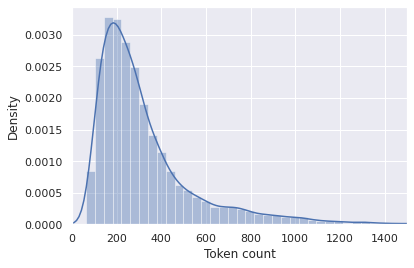

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1500]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 500-600 tokens, but for memory reasons I will experimentally choose 350 to avoid the CUDA out of memory error

In [ ]:
MAX_LEN = 350

In [ ]:
class LyricsDataset(Dataset):

    def __init__(self, lyrics, genres, tokenizer, max_len):
        self.lyrics = lyrics
        self.genres = genres
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.lyrics)
    
    def __getitem__(self, item):
        lyric = str(self.lyrics[item])
        genre = self.genres[item]

        encoding = self.tokenizer.encode_plus(
        lyric,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
        )

        return {
        'lyric_text': lyric,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'genres': torch.tensor(genre, dtype=torch.long)
        }

In [ ]:
RANDOM_SEED = 43
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((16661, 2), (1852, 2), (7935, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = LyricsDataset(
        lyrics=df.Lyrics.to_numpy(),
        genres=df.Genre.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4)

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['lyric_text', 'input_ids', 'attention_mask', 'genres'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['genres'].shape)

torch.Size([16, 350])
torch.Size([16, 350])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
    )['last_hidden_state'].shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)['pooler_output'].shape

torch.Size([1, 768])

In [ ]:
class LyricsClassifier(nn.Module):

    def __init__(self, n_classes):
        super(LyricsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        # I use a dropout layer for some regularization and a fully-connected layer for our output
    
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
            )['pooler_output']
        output = self.drop(pooled_output)
        return self.out(output) 

In [ ]:
model = LyricsClassifier(10)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 350])
torch.Size([16, 350])


The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["genres"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["genres"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.7647588611106726 accuracy 0.383650441149991
Val   loss 1.6237767585392655 accuracy 0.42764578833693306

Epoch 2/4
----------
Train loss 1.38611540753187 accuracy 0.5272192545465458
Val   loss 1.55461341399571 accuracy 0.4605831533477322

Epoch 3/4
----------
Train loss 1.0834839254789297 accuracy 0.644439109297161
Val   loss 1.628732222421416 accuracy 0.45896328293736505

Epoch 4/4
----------
Train loss 0.8656956327796669 accuracy 0.7246263729668087
Val   loss 1.7096524279693077 accuracy 0.4573434125269979



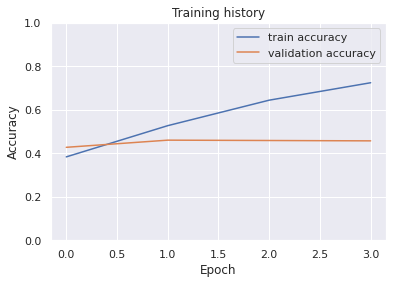

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.46212980466288595

The best accuracy so far, you can still easily see that I do not have a learning curve and that the network has a lot of overfitting. The learning curve is non-existent probably because the lyrics are in several languages, but also because I cut quite a lot out of context (max_len = 350)
______________________________________________________________________________________________________________________

# TORCHTEXT + EmbeddingBag 

In [ ]:
import torchtext

BATCH_SIZE = 16


import torch.nn as nn
import torch.nn.functional as F


class LyricsClasificator(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
df = pd.read_csv(data_dir_drive + 'Lyrics-Genre-Train.csv')

In [ ]:
def to_code(genre):
    if genre  == 'Country':
        return 0
    elif genre  == 'Electronic':
        return 1
    elif genre  == 'Folk':
        return 2
    elif genre  == 'Hip-Hop':
        return 3
    elif genre  == 'Indie':
        return 4
    elif genre  == 'Jazz':
        return 5
    elif genre  == 'Metal':
        return 6
    elif genre  == 'Pop':
        return 7
    elif genre  == 'R&B':
        return 8
    else: 
        return 9

df['Genre'] = df.Genre.apply(to_code)
del df['Song']
del df['Song year']
del df['Artist']
del df['Track_id']

In [ ]:
df_test = pd.read_csv(data_dir_drive + 'Lyrics-Genre-Test-GroundTruth.csv')

In [ ]:
df_test['Genre'] = df_test.Genre.apply(to_code)
del df_test['Song']
del df_test['Song year']
del df_test['Artist']
del df_test['Track_id']
df_test.head()

,Genre,Lyrics
0,3,Most folks spend their days daydreaming of fin...
1,4,Take your cold hands and put them on my face\n...
2,6,Are you ready it's time for war\nWe'll break d...
3,7,You ask me why I change the color of my hair\n...
4,3,Do you believe in magic in a young girl's hear...


In [ ]:
!pip install -U torchtext==0.8.0

Requirement already up-to-date: torchtext==0.8.0 in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def build_vocab(data, transforms):
    def apply_transforms(data):
        for line in data:
            tokens = transforms(line)
            yield tokens
    return build_vocab_from_iterator(apply_transforms(data), len(data))

tokenizer = get_tokenizer('basic_english')
vocab = build_vocab(df['Lyrics'], tokenizer)
vocab_test = build_vocab(df_test['Lyrics'], tokenizer)

100%|██████████| 7935/7935 [00:01<00:00, 7723.82lines/s]


In [ ]:
class LanguageModelingDataset(torch.utils.data.Dataset):
    """Defines a dataset for language modeling.
       Currently, we only support the following datasets:
             - WikiText2
             - WikiText103
             - PennTreebank
             - WMTNewsCrawl
    """

    def __init__(self, data, vocab, transform):
        """Initiate language modeling dataset.
        Args:
            data: a tensor of tokens. tokens are ids after
                numericalizing the string tokens.
                torch.tensor([token_id_1, token_id_2, token_id_3, token_id1]).long()
            vocab: Vocabulary object used for dataset.
            transform: Text string transform.
        """

        super(LanguageModelingDataset, self).__init__()
        self.vocab = vocab
        self.transform = transform
        self.data = data

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        for x in self.data:
            yield x

    def get_vocab(self):
        return self.vocab

In [ ]:
def text_transform(line):
    return torch.tensor([vocab[token] for token in tokenizer(line)], dtype=torch.long)

In [ ]:
DS = LanguageModelingDataset(list(zip(list(map(text_transform, df.Lyrics.tolist())), df.Genre.tolist())), vocab, text_transform)
DS_test = LanguageModelingDataset(list(zip(list(map(text_transform, df_test.Lyrics.tolist())), df_test.Genre.tolist())), vocab_test, text_transform)

DS[0]

(tensor([    4,   144,     9,   104,    15,     8,     5,   576,     3,   115,
           227,   220,    30,    11,     3,     4,   233, 13495,     5,   104,
            15,     8,     5,  2402,     7,   170,  2613,   347,    11,     3,
          2179,   294,    25,   201,   420,    12,    12,    12,    10,  1185,
            12,     4,  4057,    13,   131,     3,     4,   290,    25,     5,
           213,     3,     4,    60,     5, 18704,    18,   389,     3,   115,
           227,    30,    11,     4,   648,    13,  1070,     3,     7,    10,
         43501,    13,   232,    12,    12,    12,    13,   232,    12,     4,
            60,     5,   174,     3,    13,   137,  4525,   341,    10,     3,
         24730,   232,     7,     5,  1102,   673,     3,  2172,  3142,    69,
            13,   227,     3,  2179,    29,   273,   194,    35,   122,  3381,
             9,   417,    12,    12,    12,  3142,   194,    18,    11,    12,
             4,   341,    13,   131,     3,  2179,  

In [ ]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 32
NUN_CLASS = 10
model = LyricsClasificator(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[1] for entry in batch])
    text = [entry[0] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [ ]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
        

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [ ]:
from torch.utils.data.dataset import random_split
import time
N_EPOCHS = 50
min_valid_loss = float('inf')
history = defaultdict(list)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_dataset = DS
train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len])

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(valid_acc)

    if valid_acc > best_acc:
        best_acc = valid_acc
        best_model_wts = copy.deepcopy(model.state_dict()) #I remember the best model for every epoch

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 0.0863(train)	|	Acc: 61.8%(train)
	Loss: 0.0035(valid)	|	Acc: 57.0%(valid)
Epoch: 2  | time in 0 minutes, 1 seconds
	Loss: 0.0528(train)	|	Acc: 71.2%(train)
	Loss: 0.0059(valid)	|	Acc: 43.0%(valid)
Epoch: 3  | time in 0 minutes, 1 seconds
	Loss: 0.0479(train)	|	Acc: 74.1%(train)
	Loss: 0.0013(valid)	|	Acc: 72.5%(valid)
Epoch: 4  | time in 0 minutes, 1 seconds
	Loss: 0.0434(train)	|	Acc: 76.6%(train)
	Loss: 0.0015(valid)	|	Acc: 67.8%(valid)
Epoch: 5  | time in 0 minutes, 1 seconds
	Loss: 0.0402(train)	|	Acc: 78.1%(train)
	Loss: 0.0052(valid)	|	Acc: 56.8%(valid)
Epoch: 6  | time in 0 minutes, 1 seconds
	Loss: 0.0375(train)	|	Acc: 79.6%(train)
	Loss: 0.0017(valid)	|	Acc: 70.5%(valid)
Epoch: 7  | time in 0 minutes, 1 seconds
	Loss: 0.0348(train)	|	Acc: 81.3%(train)
	Loss: 0.0010(valid)	|	Acc: 67.9%(valid)
Epoch: 8  | time in 0 minutes, 1 seconds
	Loss: 0.0323(train)	|	Acc: 82.9%(train)
	Loss: 0.0013(valid)	|	Acc: 73.2%(valid)
Epoch: 9  | time

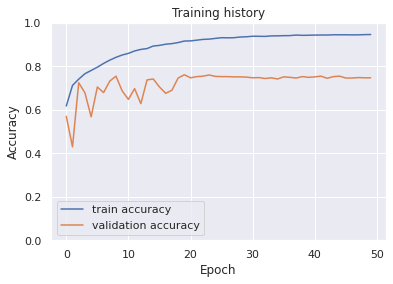

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
model.load_state_dict(best_model_wts)
print('Checking the results of test dataset...')
test_loss, test_acc = test(DS_test)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0006(test)	|	Acc: 36.2%(test)


Although there is a very nice learning curve (we can say that it is the only model so far that has overfitting) the model fails miserably on the test set, because the vacabular from the test set is quite different from the one learned on the train.